This notebook is based on the tutorial in Chapter 3 of the book "Hands-on Machine Learning" by Aurelien Geron.

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

some_digit is an array of shape: (784,)


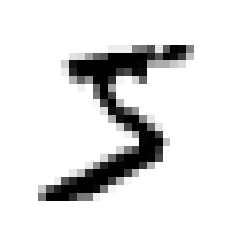

In [53]:
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = X[0]
print('some_digit is an array of shape: ' + str(some_digit.shape))

some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [4]:
#label consistent with writing
y[0]

'5'

In [5]:
#cast labels to integers
import numpy as np
y = y.astype(np.uint8)

In [6]:
#train test split (dataset already pre-shuffled, so this suffices)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a binary classifier

We begin by creating a classifier to predict 5s and non-5s.

In [7]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits. 
y_test_5 = (y_test == 5)

### SGD Classifier

In [8]:
#SGDClassifier applies regular Stochastic Gradient Descent to train a linear SVM classifier.
#It does not converge as fast as LinearSVC, but it can be useful to handle huge datasets that do not fit in memory
from sklearn.linear_model import SGDClassifier 
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
#predict the first instance of the training set
#correctly classifies it as a 5!
sgd_clf.predict([some_digit])

array([ True])

In [10]:
from sklearn.model_selection import cross_val_score

#95%+ accuracy on every fold! But what about class imbalance?
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [11]:
from sklearn.base import BaseEstimator

#this estimator always guesses "not 5"
class Never5Classifier(BaseEstimator): 
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()

#90%+ accuracy. This means that the dataset is ~10% 5s
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [12]:
#Let's do some cross-validation
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

# note that f1 score should only be used when recall and precision are similar
precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred), f1_score(y_train_5, y_train_pred)

(0.8370879772350012, 0.6511713705958311, 0.7325171197343846)

In [15]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                                 method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

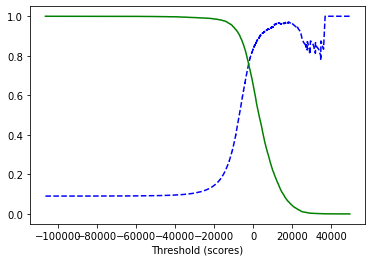

In [16]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold (scores)")
#     plt.legend(['precision','recall'])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

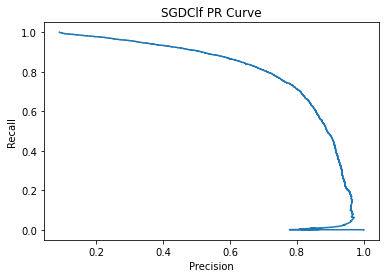

In [17]:
plt.plot(precisions, recalls)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('SGDClf PR Curve')
plt.show()

In [18]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

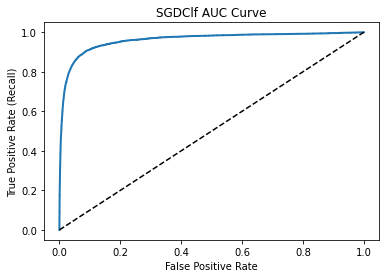

In [19]:
def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('SGDClf AUC Curve')
    
plot_roc_curve(fpr, tpr)
plt.show()

Note: Since the ROC curve is so similar to the precision/recall (or PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top- right corner).

In [20]:
#Area Under the Curve!
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### Random Forest

In [21]:
#we now compare SGDClassifier to RandomForest
#the RandomForestClassi fier class does not have a decision_function() method. It has a predict_proba() method.
#The predict_proba() method returns an array containing a row per instance and a column per class, 
    #each containing the probability that the given instance belongs to the given class
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba")

In [22]:
#use probabilities of positive class as scores for threshold in PR curve
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

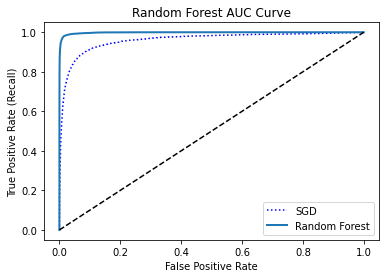

In [23]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.title('Random Forest AUC Curve')
plt.show()

#The Random forest performs better than the SGD classifier at all thresholds!

In [24]:
print(roc_auc_score(y_train_5, y_scores_forest))

0.9983436731328145


In [25]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

#Random forest has much better precision and recall, as evident in the confusion matrix
confusion_matrix(y_train_5, y_train_pred_forest)

array([[54534,    45],
       [  725,  4696]])

In [26]:
precision_score(y_train_5, y_train_pred_forest), recall_score(y_train_5, y_train_pred_forest), f1_score(y_train_5, y_train_pred_forest)

(0.9905083315756169, 0.8662608374838591, 0.9242275142688446)

# Multiclass Classification

In [27]:
#note we are now using y_train instead of y_train_5
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

#under the hood, sklearn trains 10 binary classifiers
# Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, 
    # and it automatically runs OvA 
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [28]:
# calling the decision_function method of the classifier 
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [29]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [30]:
#this produces an array of probabilities that the digit is the value of the corresponding index
#here, it predicts a 90% chance of being a 5
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [31]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.9646 , 0.96255, 0.9666 ])

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

# interestingly, scaling the data for the random forest didn't help
cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.96445, 0.96255, 0.96645])

# Error Analysis

In [36]:
y_predicts_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3, method = 'predict')

In [48]:
conf_mx = confusion_matrix(y_train, y_predicts_forest)
conf_mx

array([[5840,    1,    8,    2,    4,    9,   20,    1,   35,    3],
       [   1, 6635,   43,   11,   13,    5,    6,   13,   12,    3],
       [  27,   12, 5749,   30,   32,    4,   20,   37,   41,    6],
       [   7,    7,   91, 5811,    3,   63,    7,   49,   61,   32],
       [  12,   13,   14,    1, 5645,    0,   28,   14,   17,   98],
       [  20,    9,    9,   64,   12, 5198,   53,    6,   31,   19],
       [  26,   11,    5,    0,   12,   46, 5803,    0,   15,    0],
       [   4,   24,   58,    6,   37,    1,    0, 6037,   11,   87],
       [   9,   35,   44,   52,   26,   52,   27,    5, 5525,   76],
       [  21,   10,   14,   76,   75,   15,    3,   58,   45, 5632]])

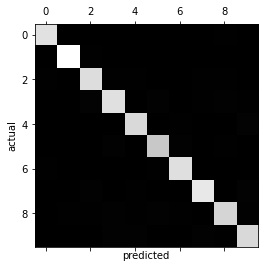

In [50]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

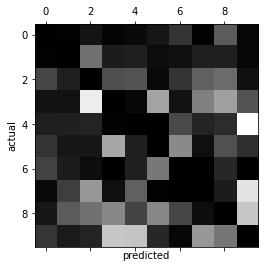

In [46]:
#while the confusion matrix is useful, we want to see where it's most likely to get errors
# we can do this by simply setting the diagonals to 0
np.fill_diagonal(conf_mx, 0)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.xlabel('predicted')
plt.ylabel('actual')

# based on these results, 2s and 3s are likely to be mixed up, 4s and 9s are likely to be mixed up, and 7s and 9s
plt.show()

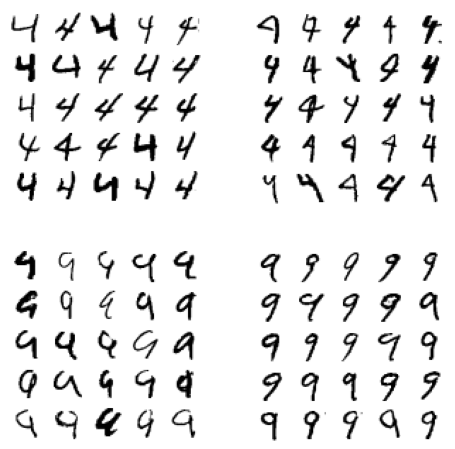

In [55]:
# we can examine correct and incorrect predictions
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
cl_a, cl_b = 4, 9
# X_zz = X_train[(y_train = ACTUAL) & (y_predicts_forest = PREDICTED)]
X_aa = X_train[(y_train == cl_a) & (y_predicts_forest == cl_a)] #correct 4s
X_ab = X_train[(y_train == cl_a) & (y_predicts_forest == cl_b)] #actual 4s, pred 9s
X_ba = X_train[(y_train == cl_b) & (y_predicts_forest == cl_a)] #actual 9s, pred 4s
X_bb = X_train[(y_train == cl_b) & (y_predicts_forest == cl_b)] #correct 9s
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

#left = classified as 4s
#right = classified as 9s